In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import category_encoders as ce

from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import re
import os
sns.set_theme(style="darkgrid")

path = os.path.dirname(os.getcwd()).replace('\\', '/') + '/'


import warnings
warnings.simplefilter("ignore", UserWarning)

warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)

In [3]:
hotels_data = pd.read_csv(path + 'data_set\hotels.csv')

# Подсчитываем количество дубликатов и удаляем их 
print(f'Количество дубликатов составляет: {hotels_data.duplicated().sum()}')
hotels_data.drop_duplicates()


Количество дубликатов составляет: 307


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,9.2,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,8.3,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084
386801,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,9.2,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066


In [4]:
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

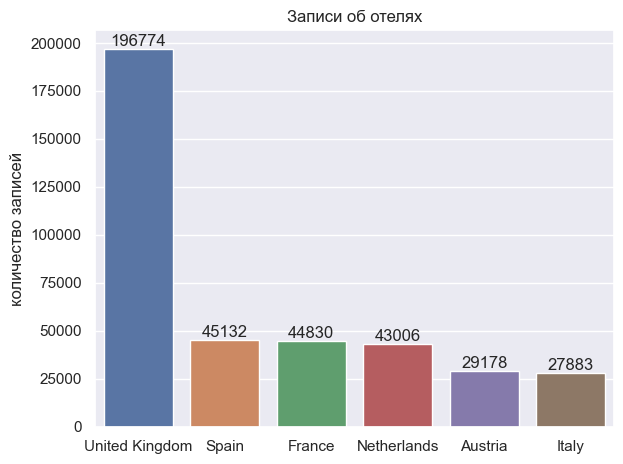

In [5]:
# Записываем категориальные признаки в отдельный датафрейм
ObjDataHotel = hotels_data[['hotel_address', 'hotel_name', 
                            'reviewer_nationality', 'negative_review', 
                            'positive_review', 'tags', 'days_since_review']]



# Из признака 'hotel_address' мы можем извлечь название страны
ObjDataHotel['hotel_country'] = \
    ObjDataHotel['hotel_address'].apply(lambda x: x.split(' ')[-2:]) 
    
    
    
ObjDataHotel['hotel_country'] = \
    ObjDataHotel['hotel_country'].apply(lambda x: x[1] if x[0] != 'United' and \
        x[1] != 'Kingdom' else 'United Kingdom')
    
# Судя по всему в датафрейме указаны только столичные отели, поэтому 
# извлекать название города в отдельную переменную нет необходимости    
    
    
# Подсчитываем количество записей об отелях по странам и выводим ввиде барплота
HotelCntry_count = ObjDataHotel['hotel_country'].value_counts().to_frame()

HotelCntry_count.reset_index().rename(columns={'hotel_country':'hotel_country'})

HotelCntry_bar = sns.barplot(data=HotelCntry_count, x='hotel_country', 
                             y='count', hue='hotel_country', palette='deep',
                             errorbar=None)

HotelCntry_bar.set(title='Записи об отелях', 
                   ylabel='количество записей', xlabel='')


for i in HotelCntry_bar.containers:
    HotelCntry_bar.bar_label(i)
    
plt.tight_layout()


# Так как количество стран невелико (ниже 15) можно их закодировать с помощью 
# Ordinary Encoder
HotelCntry_dummies = pd.get_dummies(ObjDataHotel['hotel_country'], dtype=int)

In [6]:
# Оцениваем количество уникальных значений в признаке 'hotel_name'
print(f"Количество уникальных значений {ObjDataHotel['hotel_name'].nunique()}")


# Кодируем эту переменную с помощью Binary Encoder 
# так как уникальных значений значительно выше 15
BinEncoder = ce.BinaryEncoder(cols=['hotel_name'])
BinHotlname = BinEncoder.fit_transform(ObjDataHotel['hotel_name'])
BinHotlname

Количество уникальных значений 1492


,hotel_name_0,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
386798,0,1,0,1,1,1,0,1,0,1,1
386799,0,0,1,0,1,0,1,0,0,1,1
386800,0,0,1,1,0,0,0,0,1,0,0
386801,0,0,1,0,0,1,1,0,0,0,0


In [7]:
# Записываем категориальные признаки в отдельный датафрейм
ObjDataHotel = hotels_data[['hotel_address', 'hotel_name', 
                            'reviewer_nationality', 'negative_review', 
                            'positive_review', 'tags', 'days_since_review']]


# Приводим все строки в переменной 'negative_review' к нижнему регистру
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: x.lower())

# Выбираем топ 150 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
NonNegList = ObjDataHotel['negative_review'].value_counts()\
    .nlargest(150).to_frame().reset_index()



# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с истинно-отрицательными комментариями по типу "bad wifi" 
to_find = r'nois|room|leav|pric|bed|cost|applicable|parking|gym|^.*wifi$|staff|\
    |breakfast|bathroom|everything|pool|bar|view|service|location|expensive|\
        |cleanliness|weather|pillows'

# Функция возвращает None если слово в списке to_find, 
# в противном случае возвращает строку без изменений
def FindRegEx (string):
    findlst = re.findall(to_find, string)
    if len(findlst) > 0:
        return
    else:
        return string


NonNegList['negative_review'] = \
    NonNegList['negative_review'].apply(lambda x: ''.join(x.split(' ')))

NonNegList['negative_review'] = \
    NonNegList['negative_review'].apply(FindRegEx)
    
    
# Удаляем None и оставляем только уникальные значения
NonNegList.dropna(inplace=True)
NonNegList = list(set(NonNegList['negative_review']))



# Удаляем пробеды из признака 'negative_review'
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: 0 if x in NonNegList else 1)
    
NegRewMod = ObjDataHotel['negative_review'].to_frame()
    


In [8]:
# Аналогичны образом можно модифицировать признак 'positive_review'

# Приводим все строки в переменной 'negative_review' к нижнему регистру
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: x.lower())

# Выбираем топ 150 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
NonPosList = ObjDataHotel['positive_review'].value_counts()\
    .nlargest(150).to_frame().reset_index()
    


# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с истинно-отрицательными комментариями по типу "bad wifi" 
to_find = r'^na|^no'


# Функция возвращает строку если слово в списке to_find, 
# в противном случае возвращает None
def FindRegEx (string):
    findlst = re.findall(to_find, string)
    if len(findlst) > 0 or string == '':
        return string
    else:
        return 
    
    
NonPosList['positive_review'] = \
    NonPosList['positive_review'].apply(lambda x: ''.join(x.split(' ')))

NonPosList['positive_review'] = \
    NonPosList['positive_review'].apply(FindRegEx)
    
    
# Удаляем None и оставляем только уникальные значения
NonPosList.dropna(inplace=True)
NonPosList = list(set(NonPosList['positive_review']))



# Удаляем пробеды из признака 'positive_review'
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: 0 if x in NonPosList else 1)
    
PosRewMod = ObjDataHotel['positive_review'].to_frame()
    


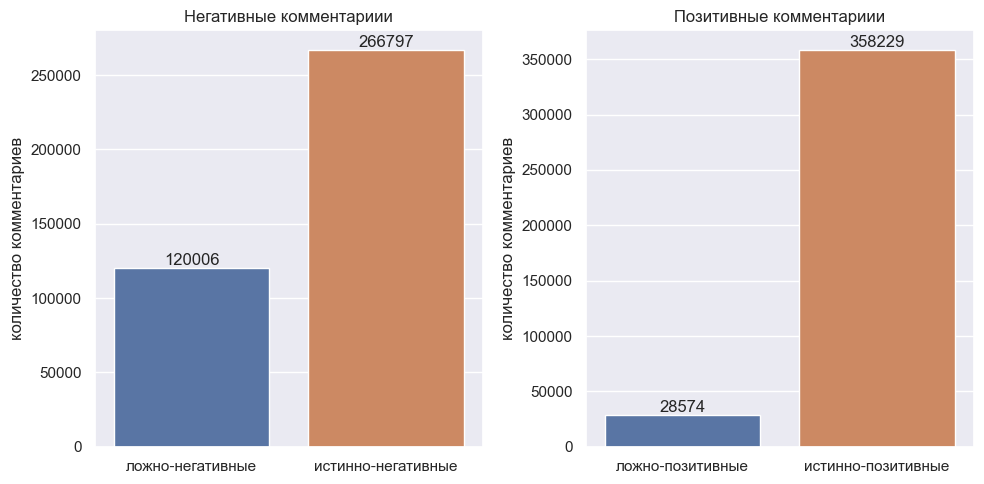

In [9]:
# Выводим в виде барплотов
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
 
    
# Барплот с негативными комментариями   
NegCom_count = ObjDataHotel['negative_review'].value_counts().to_frame()
NegCom_count.reset_index()
NegCom_count_bar = sns.barplot(data=NegCom_count, x='negative_review', ax=ax[0],
                             y='count', hue='negative_review', palette='deep',
                             errorbar=None, legend=False)

NegCom_count_bar.set(title='Негативные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-негативные', 'истинно-негативные'])


for i in NegCom_count_bar.containers:
    NegCom_count_bar.bar_label(i)
################################################################################    


# Барплот с позитивными комментариями
PosCom_count = ObjDataHotel['positive_review'].value_counts().to_frame()
PosCom_count.reset_index()
PosCom_count_bar = sns.barplot(data=PosCom_count, x='positive_review', ax=ax[1],
                             y='count', hue='positive_review', palette='deep',
                             errorbar=None, legend=False)

PosCom_count_bar.set(title='Позитивные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-позитивные', 'истинно-позитивные'])

for i in PosCom_count_bar.containers:
    PosCom_count_bar.bar_label(i)
################################################################################   



fig.tight_layout()

In [10]:
TagData = ObjDataHotel['tags'].to_frame()
TagData

,tags
0,"[' Leisure trip ', ' Couple ', ' Studio Suite ..."
1,"[' Business trip ', ' Couple ', ' Standard Dou..."
2,"[' Leisure trip ', ' Solo traveler ', ' Modern..."
3,"[' Leisure trip ', ' Solo traveler ', ' Standa..."
4,"[' Business trip ', ' Couple ', ' Standard Dou..."
...,...
386798,"[' Leisure trip ', ' Group ', ' Club Double or..."
386799,"[' Leisure trip ', ' Couple ', ' Standard Doub..."
386800,"[' Business trip ', ' Solo traveler ', ' Singl..."
386801,"[' Leisure trip ', ' Solo traveler ', ' Deluxe..."


In [ ]:
TagData = ObjDataHotel['tags'].to_frame()

# Превращаем строки в списки
TagData['tags'] = \
    TagData['tags'].apply(lambda x: re.sub(r"[\[\] ']", '', x).split(','))


# Создаем признак с типом поездки triptype
triptype_lst = ['Leisuretrip', 'Businesstrip'] # Список типов поездки
TagData['triptype'] = \
    TagData['tags'].apply(lambda x: x[0] if x[0] in triptype_lst else 'NoData')


# Этот признак мы закодируем c помощью get_dummies  
triptype_data = pd.get_dummies(TagData['triptype'], dtype=int)


# удаляем первый элемент, если это был тип поездки
def TripTypeDeleter(lst):
    if lst[0] in triptype_lst:
        return lst[1:] 
    else:
        return lst

TagData['tags'] = TagData['tags'].apply(TripTypeDeleter)
################################################################################
################################################################################

# Создаем признак с количеством людей n_people_lst
n_people_lst = ['Couple', 'Solotraveler', 'Group']


TagData['n_people'] = \
    TagData['tags'].apply(lambda x: x[0] if x[0] in n_people_lst else 'NoData')
    
# Этот признак мы закодируем c помощью get_dummies  
n_people_data = pd.get_dummies(TagData['n_people'], dtype=int)


# удаляем первый элемент, если это было кол-во людей
def NPplDeleter(lst):
    if lst[0] in n_people_lst:
        return lst[1:] 
    else:
        return lst

TagData['tags'] = TagData['tags'].apply(NPplDeleter)
################################################################################
################################################################################

# Заменяем пустые списки на списки с NoData
TagData['tags'] = \
    TagData['tags'].apply(lambda x: ['NoData'] if len(x) == 0 else x)
    
# Создаем признак с детьми
withChildrn_lst = ['Familywithyoungchildren', 'Familywitholderchildren']

TagData['with_childrn'] = \
    TagData['tags'].apply(lambda x: x[0] if x[0] in withChildrn_lst else 'NoData')

# Этот признак мы закодируем c помощью get_dummies  
Childrn_data = pd.get_dummies(TagData['with_childrn'], dtype=int)
  

# удаляем первый элемент, если это было кол-во людей
def ChildrnDeleter(lst):
    if lst[0] in withChildrn_lst:
        return lst[1:] 
    else:
        return lst

TagData['tags'] = TagData['tags'].apply(ChildrnDeleter)
################################################################################
################################################################################

# Заменяем пустые списки на списки с NoData
TagData['tags'] = \
    TagData['tags'].apply(lambda x: ['NoData'] if len(x) == 0 else x)
    

TagData['with_friends'] = \
    TagData['tags'].apply(lambda x: x[0] if x[0] == 'Travelerswithfriends' else 'NoData')

# Этот признак мы закодируем с помощью ord encoder
Friends_data = TagData['with_friends'].replace({'Travelerswithfriends':1,
                                                'NoData':0})
  

# удаляем первый элемент, если это было кол-во людей
def FriendsDeleter(lst):
    if lst[0] == 'Travelerswithfriends':
        return lst[1:] 
    else:
        return lst
    
TagData['tags'] = TagData['tags'].apply(FriendsDeleter)
################################################################################
################################################################################


TagData['tags'].to_frame()





C:\Users\Yarik\AppData\Local\Temp\ipykernel_22904\2202093708.py:86: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Friends_data = TagData['with_friends'].replace({'Travelerswithfriends':1,


,tags
0,"[StudioSuite, Stayed2nights, Submittedfromamob..."
1,"[StandardDoubleRoom, Stayed1night]"
2,"[ModernDoubleRoomEcho, Stayed3nights, Submitte..."
3,"[StandardRoomwith1DoubleBed, Stayed1night]"
4,"[StandardDoubleorTwinRoom, Stayed6nights]"
...,...
386798,"[ClubDoubleorTwinRoom, Stayed2nights, Submitte..."
386799,"[StandardDoubleRoom, Stayed4nights, Submittedf..."
386800,"[SingleRoom, Stayed1night]"
386801,"[DeluxeDoubleRoom, Stayed2nights]"


In [25]:
#Travelerswithfriends
Friends_data.value_counts()

with_friends
0    385173
1      1630
Name: count, dtype: int64

In [14]:
TagData['value_count'] = TagData['tags'].apply(lambda x: x[0] if len(x)>0 else None)
TagData['value_count'].value_counts().to_frame()


,count
value_count,
DoubleRoom,26232
StandardDoubleRoom,24025
SuperiorDoubleRoom,23422
DeluxeDoubleRoom,18526
DoubleorTwinRoom,16642
...,...
StandardDoubleorTwinRoomwithExtraBed,1
ChampsElysesPrestigeJuniorSuite,1
QuadrupleRoom2Adults2Children,1


In [15]:
TagData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          386803 non-null  object
 1   triptype      386803 non-null  object
 2   n_people      386803 non-null  object
 3   with_childrn  386803 non-null  object
 4   value_count   386791 non-null  object
dtypes: object(5)
memory usage: 14.8+ MB
